# Covid-19 Situation in San Diego
I keep checking [San Diego County's Covid-19 webpage](https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html) for up-to-date stats. I'm interested in the number of new cases per day, since that's what tells us if Covid-19 is spreading at an exponential rate (which would be _really_ scary – see [Simulating an epidemic](https://www.youtube.com/watch?v=gxAaO2rsdIs) by Grant Sanderson of 3blue1brown). The county website has new cases per day already, so perfect, right? The thing is, if you check the number of new _tests_ by day, you'll see that it looks awfully like the number of new cases per day. Now what I'm wondering is whether the new cases per day is indicative of _actual_ new cases or only the number of tests.

First let's get the data.

In [1]:
import requests
import datetime
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

figsize = (15, 3)

We can find the query URL [here](https://sdgis-sandag.opendata.arcgis.com/datasets/covid-19-statistics-san-diego-county?orderBy=date&orderByAsc=false&selectedAttribute=tests). SANDAG has some amazing datasets with great documentation by the way. I'd highly suggest anyone interested in Data Science who lives in the San Diego area to go check out the other data sets they have.

In [2]:
query_url = 'https://gis-public.sandiegocounty.gov/arcgis/rest/services/Hosted/COVID_19_Statistics_San_Diego_County/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json'
response = requests.get(query_url)

if response.status_code == 200:
    print('Successfully ran API query')

Successfully ran API query


In [3]:
response.json().keys()

dict_keys(['exceededTransferLimit', 'features', 'fields', 'geometryType', 'spatialReference', 'globalIdFieldName', 'objectIdFieldName', 'hasZ', 'hasM'])

Alright, most of those are just extra metadata. What we care about is in `features`.

In [4]:
len(response.json()['features'])

75

We have one entry per day since mid-March when California started quarantining.

In [5]:
# we're working with such a small dataset that we don't have to worry about computation time.
# It'd probably take me longer to optimize than the time I'd save optimizing.
example = response.json()['features'][0]
cols = example['attributes'].keys()
df = pd.DataFrame(columns=cols)

for feature in response.json()['features']:
    df = df.append(pd.Series(feature['attributes']), ignore_index=True)

#df.set_index('objectid', inplace=True)
df.sort_values('date', inplace=True)

df.head()

,objectid,date,tests,positives,hospitalized,icu,deaths,newcases,age_9,age10_19,...,age80_plus,ageunknow,age20_29,genderfemale,gendermale,gendeunk,age30_39,globalid,newtests,rolling_perc_pos_cases
31,87,1583568000000,None,1,0,0,0,1,None,None,...,None,None,None,None,None,None,None,{CE98E5A7-7D8E-4D20-BC84-069A17D43232},None,None
32,88,1583654400000,None,2,0,0,0,1,None,None,...,None,None,None,None,None,None,None,{8AC07123-E9DA-4D83-9720-7BF93E4B6C44},None,None
33,89,1583740800000,None,2,0,0,0,0,None,None,...,None,None,None,None,None,None,None,{52083240-452D-41A6-BD0F-2D424B2745BC},None,None
34,90,1583827200000,None,4,0,0,0,2,None,None,...,None,None,None,None,None,None,None,{9DF87361-2D53-4A06-8DF9-A986B660061D},None,None
3,59,1583913600000,123,5,None,None,None,1,None,None,...,None,None,None,None,None,None,None,{78698F35-A6E9-48CB-8C8D-67A70EC15C1D},None,None


Alright, data is there, but not exactly in the format we want.

First, let's convert the date from an integer to a datetime. I'm not completely familiar with ARCGIS data but the metadata says this is of type esriFieldTypeDate with length 29. A [post on StackOverflow](https://stackoverflow.com/questions/17231711/how-to-create-datetime-from-a-negative-epoch-in-python/17231712) shows us how to convert this into a datetime object.

In [6]:
datetime.datetime(1970, 1, 1) + datetime.timedelta(seconds=(1583568000000/1000))

datetime.datetime(2020, 3, 7, 8, 0)

Let's double check this. On the [data page](https://sdgis-sandag.opendata.arcgis.com/datasets/covid-19-statistics-san-diego-county/data?orderBy=date&orderByAsc=false&selectedAttribute=tests) we see that objectid 133 is May 21.

In [7]:
datetime.datetime(1970, 1, 1) + datetime.timedelta(seconds=(df[df['objectid'] == 133].date.values[0]/1000))

datetime.datetime(2020, 5, 20, 8, 0)

The hours are a little off (should be 1:00AM), but this is fine since we only care about the day.

In [8]:
df['date'] = df['date'].apply(lambda x: datetime.datetime(1970, 1, 1) + datetime.timedelta(seconds=(x/1000)))
df['date'] = df['date'].dt.strftime('%m/%d')
df.sort_values('date', inplace=True)

In [9]:
df.head()

,objectid,date,tests,positives,hospitalized,icu,deaths,newcases,age_9,age10_19,...,age80_plus,ageunknow,age20_29,genderfemale,gendermale,gendeunk,age30_39,globalid,newtests,rolling_perc_pos_cases
31,87,03/07,None,1,0,0,0,1,None,None,...,None,None,None,None,None,None,None,{CE98E5A7-7D8E-4D20-BC84-069A17D43232},None,None
32,88,03/08,None,2,0,0,0,1,None,None,...,None,None,None,None,None,None,None,{8AC07123-E9DA-4D83-9720-7BF93E4B6C44},None,None
33,89,03/09,None,2,0,0,0,0,None,None,...,None,None,None,None,None,None,None,{52083240-452D-41A6-BD0F-2D424B2745BC},None,None
34,90,03/10,None,4,0,0,0,2,None,None,...,None,None,None,None,None,None,None,{9DF87361-2D53-4A06-8DF9-A986B660061D},None,None
3,59,03/11,123,5,None,None,None,1,None,None,...,None,None,None,None,None,None,None,{78698F35-A6E9-48CB-8C8D-67A70EC15C1D},None,None


Okay, now that we have the data in the format we want it, let's try our first approach. Let's just overlay the two graphs:

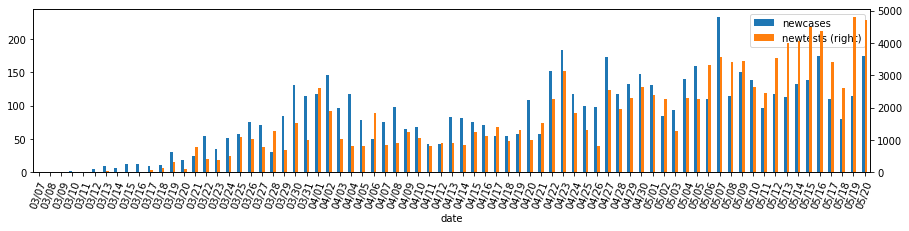

In [10]:
df.set_index('date')[['newcases', 'newtests']].plot.bar(figsize=figsize, secondary_y= 'newtests', rot=70);

There's definitely some correlation in there.

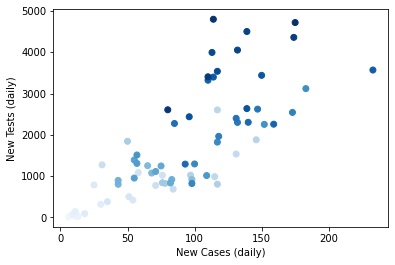

In [15]:
plt.scatter(df['newcases'].values, df['newtests'].values, c=df['objectid']/df['objectid'].max(), cmap='Blues')
plt.ylabel('New Tests (daily)')
plt.xlabel('New Cases (daily)');